In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm_notebook as tq
from sklearn.utils import resample,shuffle
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
import pickle

To avoid overfitting we will simplify our ensembel model, there were 100 models, which can be reduced.

if we talk about range, with 100 models it gives slightly better accuracy than 3 model ensemble (diffrence of 1.5%) at the cost of overfitting issue, after trying multiple values i have decided to go with 3 model ensemble

In [129]:
train=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_FE_manual_EX.csv')
test=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_FE_manual_EX.csv')
y_train=pd.read_csv('/content/y_train.csv')
sample=pd.read_csv('/content/sample_submission.csv')

In [130]:
# train dataset, merging with class labels
train=pd.merge(train,y_train,on='series_id')


In [131]:
# unwanted columns of test dataset
test=test.drop(columns=test.columns[0:18])

In [132]:
test

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_mad,orientation_X_med,orientation_X_skew,orientation_X_range,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_mean,orientation_X_abs_std,orientation_X_abs_avg,orientation_X_abs_range,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_mad,orientation_Y_med,orientation_Y_skew,orientation_Y_range,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_mean,orientation_Y_abs_std,orientation_Y_abs_avg,orientation_Y_abs_range,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_mad,orientation_Z_med,...,euler_z_abs_max,euler_z_abs_min,euler_z_abs_mean,euler_z_abs_std,euler_z_abs_avg,euler_z_abs_range,total_angular_velocity_mean,total_angular_velocity_min,total_angular_velocity_max,total_angular_velocity_std,total_angular_velocity_mad,total_angular_velocity_med,total_angular_velocity_skew,total_angular_velocity_range,total_angular_velocity_max_to_min,total_angular_velocity_mean_abs_change,total_angular_velocity_mean_change_of_abs_change,total_angular_velocity_abs_max,total_angular_velocity_abs_min,total_angular_velocity_abs_mean,total_angular_velocity_abs_std,total_angular_velocity_abs_avg,total_angular_velocity_abs_range,total_linear_acceleration_mean,total_linear_acceleration_min,total_linear_acceleration_max,total_linear_acceleration_std,total_linear_acceleration_mad,total_linear_acceleration_med,total_linear_acceleration_skew,total_linear_acceleration_range,total_linear_acceleration_max_to_min,total_linear_acceleration_mean_abs_change,total_linear_acceleration_mean_change_of_abs_change,total_linear_acceleration_abs_max,total_linear_acceleration_abs_min,total_linear_acceleration_abs_mean,total_linear_acceleration_abs_std,total_linear_acceleration_abs_avg,total_linear_acceleration_abs_range
0,0.919651,0.912080,0.92796,0.004669,0.004003,0.919455,0.102039,0.015880,1.017411,0.000125,0.000000e+00,0.92796,0.912080,0.919651,0.004650,0.920020,0.015880,-0.362914,-0.38193,-0.34109,0.011876,0.010233,-0.363610,0.146873,0.04084,0.893069,0.000322,4.761905e-07,0.38193,0.34109,0.362914,0.011829,0.361510,0.04084,-0.047720,-0.050618,-0.044415,0.001887,0.001605,-0.047874,...,0.790892,0.702145,0.749438,0.025732,0.746518,0.088747,0.273075,0.189096,0.378947,0.040267,0.033190,0.266701,0.382856,0.189852,2.003998,0.011368,-0.000110,0.378947,0.189096,0.273075,0.040110,0.284021,0.189852,9.940434,8.664897,11.532641,0.615466,0.488101,9.874685,0.339974,2.867743,1.330961,0.452794,-0.000440,11.532641,8.664897,9.940434,0.613057,10.098769,2.867743
1,0.043135,-0.024045,0.10948,0.039537,0.034233,0.043158,-0.017308,0.133525,-4.553130,0.001051,-3.412698e-07,0.10948,0.000013,0.047782,0.033593,0.054747,0.109467,-0.987147,-0.98881,-0.98290,0.001791,0.001527,-0.987925,0.888611,0.00591,0.994023,0.000049,5.555556e-07,0.98881,0.98290,0.987147,0.001784,0.985855,0.00591,-0.147972,-0.149170,-0.146110,0.000988,0.000857,-0.148145,...,3.141491,2.917472,3.043414,0.068901,3.029482,0.224019,0.844875,0.743601,0.964902,0.061247,0.052419,0.839689,0.168715,0.221301,1.297607,0.013199,-0.000032,0.964902,0.743601,0.844875,0.061007,0.854252,0.221301,9.846888,8.897287,10.881215,0.363547,0.291185,9.810047,0.477554,1.983928,1.222981,0.267639,0.004695,10.881215,8.897287,9.846888,0.362124,9.889251,1.983928
2,-0.914825,-0.915200,-0.91438,0.000259,0.000235,-0.914810,0.001585,0.000820,0.999104,0.000016,3.174603e-07,0.91520,0.914380,0.914825,0.000258,0.914790,0.000820,0.376669,0.37579,0.37787,0.000681,0.000615,0.376425,0.410494,0.00208,1.005535,0.000034,-4.405647e-19,0.37787,0.37579,0.376669,0.000679,0.376830,0.00208,0.051761,0.050984,0.052354,0.000434,0.000385,0.051855,...,0.782441,0.778230,0.780012,0.001334,0.780335,0.004211,0.093051,0.01

In [133]:
# now we dont need these two columns as it was useful for merging with classes
train=train.drop(columns=['series_id','group_id'])

In [134]:
# train has class label as column while test doesnt have that column
train.shape,test.shape

((3810, 256), (3816, 255))

In [135]:
X=train.drop(columns='surface')
Y=train.surface.values


In [136]:
# Min max scaller to get evrything in range 0 to 1
std=MinMaxScaler()
train_X=pd.DataFrame(std.fit_transform(X),columns=X.columns)
test_X=pd.DataFrame(std.fit_transform(test),columns=test.columns)

In [137]:
X_train,X_test,Y_train,Y_test=train_test_split(train_X,Y,stratify=Y,test_size=0.2)

In [139]:
# somte for class imbalance
smote=SMOTE()
X_train,Y_train=smote.fit_resample(X_train,Y_train)
X_train.shape

(5607, 255)

In [140]:
# splitting train in 50-50% for ensemble
X_train=pd.DataFrame(X_train)
X_train['y_train']=Y_train
X_train=shuffle(X_train)

D1_x=X_train.iloc[0:2803]
D2_x=X_train.iloc[2804:-1]

In [141]:
D2_y=D2_x.y_train.values
D2_x=D2_x.drop(columns='y_train')

In [142]:
# 3 models for ensemble
xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
RF=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
clf=MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [156]:

train_X=pd.DataFrame()
test_X=pd.DataFrame()
test_data=pd.DataFrame()

for i in range(3):

    if i==0:
        model=xgb     
    elif i==1:
        model=RF
    elif i==2:
        model=clf
        
    d=resample(D1_x,replace=True,n_samples=2500) ## creating sub samples from our first half of train data
    D_y=d.y_train.values
    D_x=d.drop(columns='y_train')

    model.fit(np.array(D_x),D_y)        ## fitting sub samples to chosen model based on condition above
    if i==0:
        pickle.dump(model, open('XGB_prob.sav', 'wb'))
    elif i==1:
        pickle.dump(model, open('RF_prob.sav', 'wb'))
    elif i==2:
        pickle.dump(model, open('NB_prob.sav', 'wb'))
    pred=pd.DataFrame(model.predict_proba(np.array(D2_x)))  # predicting for D2 set which is second half of the train data
    pred2=pd.DataFrame(model.predict_proba(np.array(X_test))) # predicting for actual X_test data so that we can create dataset 
    pred3=pd.DataFrame(model.predict_proba(np.array(test)))   # predicting for kaggle test dataset

    train_X=pd.concat([train_X,pred],axis=1)  # creating dataframe from our predictions
    test_X=pd.concat([test_X,pred2],axis=1)
    test_data=pd.concat([test_data,pred3],axis=1)

In [147]:
## tuning for newly created data set of predictions 
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15],
     'n_estimators':[100,200,300],
     'max_depth':[3,5,10,50],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,n_iter=5,verbose=0,n_jobs=-1,)
random_cfl.fit(np.array(train_X), D2_y)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [148]:
random_cfl.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=1)

In [157]:
# training on newly created dataset
model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=1)
model.fit(np.array(train_X),D2_y)
pred=model.predict(np.array(test_X))

In [158]:
pickle.dump(model, open('XGB_final.sav', 'wb'))

In [150]:
# accuracy on validation dataset
accuracy_score(Y_test,pred)

0.9094488188976378

In [151]:
# prediction for kaggle test data
pred=model.predict(np.array(test_data))

In [154]:
# preparing submission file
sample['surface']=pred
sample.to_csv('submission3.csv',index=False)

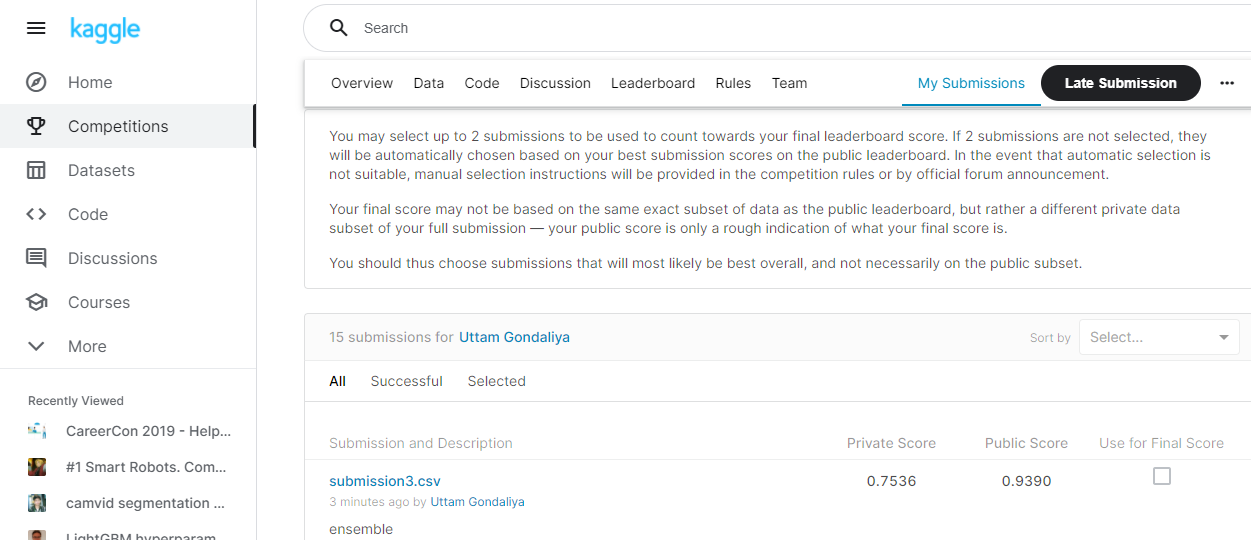

### And with this we get score of 0.93 on kaggle public leaderboard and 0.75 on private leaderboard, both are equivalent as my rank is 22 on both leaderboard out of total 1443 entries which means i am in top 1.45% of both the leaderboards